## Movie Revenue Prediction 



In [247]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 Needed
import sklearn
from sklearn.preprocessing import Imputer

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# "Sequential" model lets us to define a stack of neural network layers
from keras.models import Sequential
# import the "core" layers:
from keras.layers import Dense, Dropout, Activation, Flatten
# CNN
from keras.layers import Convolution2D, MaxPooling2D
# import some utilities to transform our data
from keras.utils import np_utils
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import ast
import warnings
warnings.filterwarnings(action="ignore")
from numpy import loadtxt
import xgboost as xgb


# 1.Getting Data

In [248]:
# Convert csv and json files into dataframes
mvrevenue = pd.read_csv('C:\\Users\\medwa\\OneDrive\\Desktop\\Movie_Revenue_Predictions.csv')
mvrevenue.head(3)

,title,tagline,revenue,budget,genres,homepage,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status
0,Avatar,Enter the World of Pandora.,2787965087,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]",en,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.","[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",12/10/09,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",961000000,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",5/19/07,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released
2,Spectre,A Plan No One Escapes,880674609,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"": ""united kingdom""}]",en,"A cryptic message from Bond’s past sends him on a trail to uncover a si

# 2. Understanding the Data: Data quality report

In [249]:
dict_columns = [ 'genres', 'production_companies','production_countries', 'spoken_languages', 'keywords']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
mvrevenue = text_to_dict(mvrevenue)

In [250]:
#How many rows?
mvrevenue.shape

(4803, 16)

In [251]:
mvrevenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 16 columns):
title                   4803 non-null object
tagline                 3959 non-null object
revenue                 4803 non-null int64
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
overview                4800 non-null object
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
dtypes: float64(1), int64(3), object(12)
memory usage: 600.5+ KB


In [253]:
# Checking the null values
mvrevenue.isnull().sum()

title                   0   
tagline                 844 
revenue                 0   
budget                  0   
genres                  0   
homepage                3091
id                      0   
keywords                0   
original_language       0   
overview                3   
production_companies    0   
production_countries    0   
release_date            1   
runtime                 2   
spoken_languages        0   
status                  0   
dtype: int64

In [254]:
# Check if there is any missing balues

for index, row in mvrevenue['runtime'][0:5].iteritems():
    print(index, row)

0 162.0
1 169.0
2 148.0
3 165.0
4 132.0


In [255]:
# Check how many missing values for runtime column

mvrevenue['runtime'].isnull().value_counts()

False    4801
True     2   
Name: runtime, dtype: int64

In [257]:
# Calculate Correlation
mvrevenue.describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,4803.0,8.226064e+07,1.628571e+08,0.0,0.0,19170001.0,92917187.0,2.787965e+09
budget,4803.0,2.904504e+07,4.072239e+07,0.0,790000.0,15000000.0,40000000.0,3.800000e+08
id,4803.0,5.716548e+04,8.869461e+04,5.0,9014.5,14629.0,58610.5,4.594880e+05
runtime,4801.0,1.068759e+02,2.261193e+01,0.0,94.0,103.0,118.0,3.380000e+02


In [258]:
# Dropped the rows with missing values since they are few

mvrevenue = mvrevenue.dropna(axis = 0, how ='any')

In [151]:
def parse_genres(raw_genres):
    
    k = raw_genres.split(',')
    # print(k)
    
    genres = []
    
    for i in range(len(k)):
        element = k[i]
        # print('--->', i, type(element), element)
        p = element.split(':')
        # print('p ->', p)
        
        key = p[0]
        key = key.lstrip().rstrip()
        # print(f"key ->{key}")
        
        if key == '"name"':
            value = p[1]
            value = value.lstrip().rstrip()
            # print(f'value -->{value}')
            value = value.split('"')
            # print(f'value -->{value}')
            genre = value[1]
            # print(f'genre -->{genre}')
            genres.append(genre)
            
    return genres


### genres
Contains all the Genres Name & TMDB Id in JSON Format

In [264]:
genres= mvrevenue.loc[mvrevenue['genres'].str.len()==1][['genres','revenue','budget','runtime']].reset_index(drop=True)

genres['genres']=genres.genres.apply(lambda x :x[0]['name'])
genres.head()

,genres,revenue,budget,runtime
0,Action,1506249360,190000000,137.0
1,Science Fiction,543934787,178000000,144.0
2,Fantasy,299370084,170000000,113.0
3,Adventure,301000000,150000000,99.0
4,Comedy,202026112,100000000,90.0


In [261]:
genres=genres.groupby(genres.genres).agg('mean')

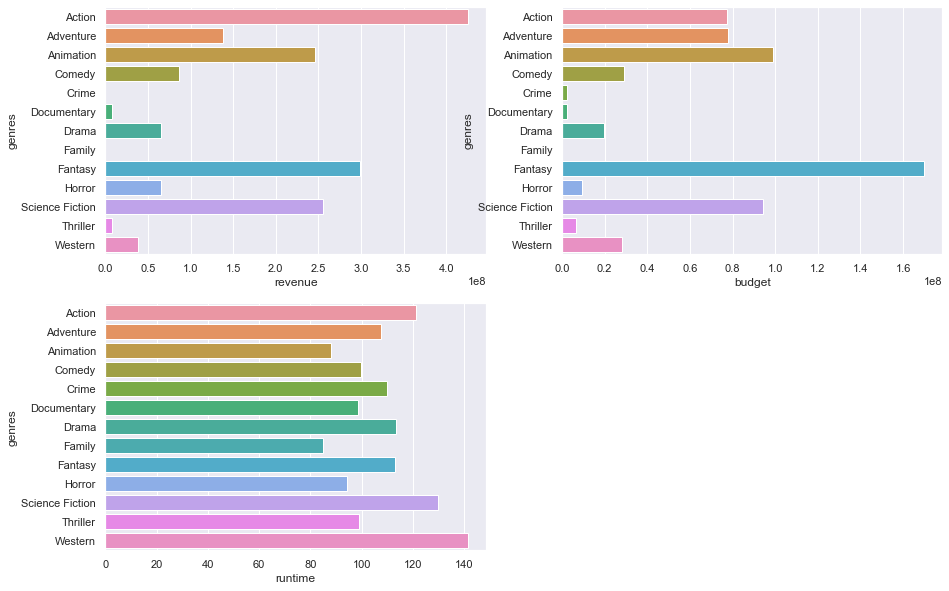

In [263]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
sns.barplot(genres['runtime'],genres.index)

In [265]:
data = mvrevenue
data[['release_month','release_day','release_year']]=data['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int) #getting the month year and day using the string split function and the / as a delimiter; eg: 5/25/2015 -> month 5/ day 25 / year 2015
data.loc[ (data['release_year'] <= 19) & (data['release_year'] < 100), "release_year"] += 2000 ## some rows have 4 digits for the year instead of 2, so the release year < 100 and > 100 is checking that
data.loc[ (data['release_year'] > 19)  & (data['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(data['release_date']) #using the pandas to_datetime function to format the data, get a Series,  and store it in a variable that is gonna be used later to get the day of week and quarter
data['release_dayofweek'] = releaseDate.dt.dayofweek
data['release_quarter'] = releaseDate.dt.quarter

Text(0.5, 1.0, 'Days of the week, from 0 - sunday,  to 6 - saturday')

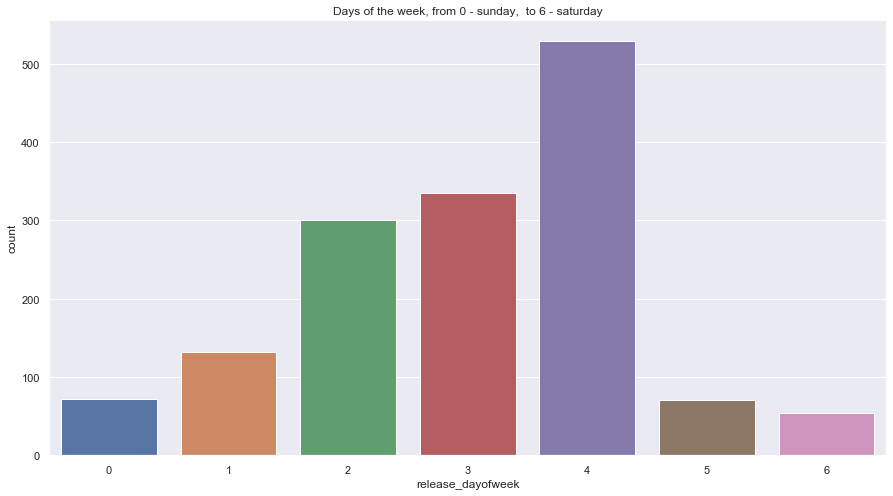

In [266]:
plt.figure(figsize=(15, 8))
sns.countplot(data['release_dayofweek'])
plt.title('Days of the week, from 0 - sunday,  to 6 - saturday')

In [152]:
'''gs_list = []

for record in df_tem['genres']:
    g = parse_genres(record)
    # print(g)
    # genres_series.append(g)
    gs_list.append(g)

gs_series = pd.Series(gs_list)

gs_series.head()

df_tem['genres'] = gs_series

print(df_tem.shape)'''

(1493, 16)


Text(0.5, 1.0, 'Distribution of movies by month')

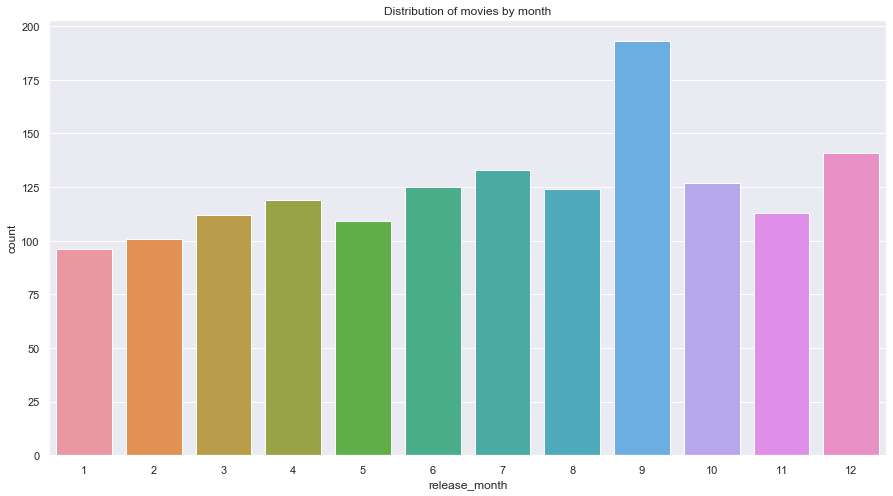

In [267]:
## -1 is the nan values in the original data, that has been replaced by -1
plt.figure(figsize=(15, 8))
sns.countplot(data['release_month']); plt.title('Distribution of movies by month')

Text(0.5, 1.0, 'Distribution of movies by days in a month')

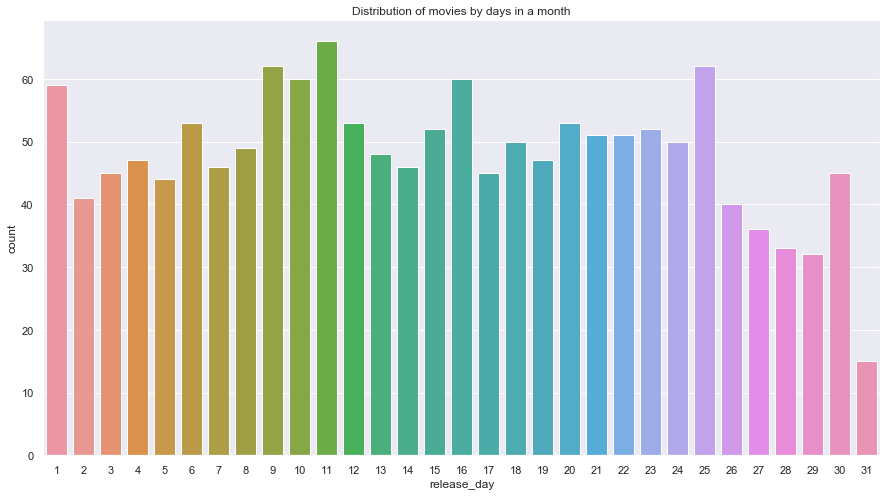

In [268]:
plt.figure(figsize=(15, 8))
sns.countplot(data['release_day']); plt.title('Distribution of movies by days in a month')

In [153]:
for genres in df_tem['genres'].values[:5]:
    print(genres)

['Action', 'Adventure', 'Fantasy', 'Science Fiction']
['Adventure', 'Fantasy', 'Action']
['Action', 'Adventure', 'Crime']
['Action', 'Crime', 'Drama', 'Thriller']
['Action', 'Adventure', 'Science Fiction']


### production_companies

In [154]:
'''gs_list = []

for record in df_tem['production_companies']:
    g = parse_genres(record)
    # print(g)
    # genres_series.append(g)
    gs_list.append(g)

gs_series = pd.Series(gs_list)

gs_series.head()

df_tem['production_companies'] = gs_series

print(df_tem.shape)'''

"gs_list = []\n\nfor record in df_tem['production_companies']:\n    g = parse_genres(record)\n    # print(g)\n    # genres_series.append(g)\n    gs_list.append(g)\n\ngs_series = pd.Series(gs_list)\n\ngs_series.head()\n\ndf_tem['production_companies'] = gs_series\n\nprint(df_tem.shape)"

In [167]:
for i in df_tem.production_companies.values[:5]:
    print(i)

[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]
[{"name": "Walt Disney Pictures", "id": 2}, {"name": "Jerry Bruckheimer Films", "id": 130}, {"name": "Second Mate Productions", "id": 19936}]
[{"name": "Columbia Pictures", "id": 5}, {"name": "Danjaq", "id": 10761}, {"name": "B24", "id": 69434}]
[{"name": "Legendary Pictures", "id": 923}, {"name": "Warner Bros.", "id": 6194}, {"name": "DC Entertainment", "id": 9993}, {"name": "Syncopy", "id": 9996}]
[{"name": "Walt Disney Pictures", "id": 2}]


### production_countries

In [101]:
for i in df_tem.production_countries.values[:5]:
    print(i)

[{"iso_3166_1": "US", "name": "United States of America"}, {"iso_3166_1": "GB", "name": "United Kingdom"}]
[{"iso_3166_1": "US", "name": "United States of America"}]
[{"iso_3166_1": "GB", "name": "United Kingdom"}, {"iso_3166_1": "US", "name": "United States of America"}]
[{"iso_3166_1": "US", "name": "United States of America"}]
[{"iso_3166_1": "US", "name": "United States of America"}]


### spoken_languages

In [160]:
gs_list = []

for record in df_tem['spoken_languages']:
    g = parse_genres(record)
    # print(g)
    # genres_series.append(g)
    gs_list.append(g)

gs_series = pd.Series(gs_list)

gs_series.head()

df_tem['spoken_languages'] = gs_series

print(df_tem.shape)

(1493, 16)


In [163]:
for i in df_tem.spoken_languages.values[:5]:
    print(i)

['English', 'Espa\\u00f1ol']
['English']
['Fran\\u00e7ais', 'English', 'Espa\\u00f1ol', 'Italiano', 'Deutsch']
['English']
['English']


### keywords

In [165]:
gs_list = []

for record in df_tem['keywords']:
    g = parse_genres(record)
    # print(g)
    # genres_series.append(g)
    gs_list.append(g)

gs_series = pd.Series(gs_list)

gs_series.head()

df_tem['keywords'] = gs_series

print(df_tem.shape)

(1493, 16)


In [166]:
for i in df_tem.keywords.values[:1]:
    print(i)

['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d']


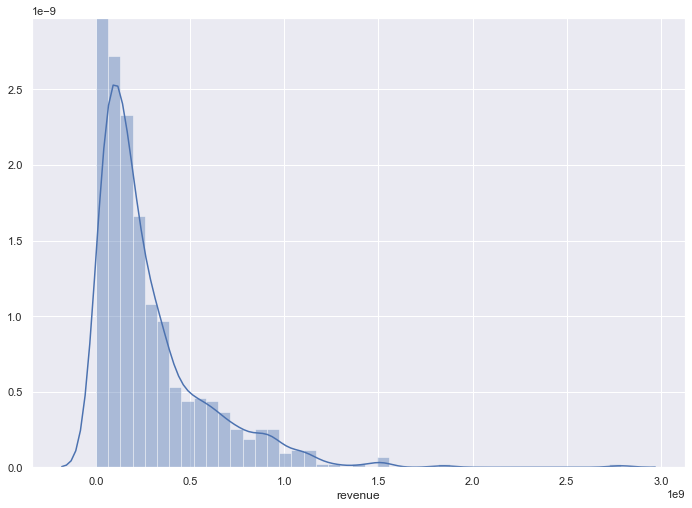

In [192]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.distplot(df_tem['revenue'])

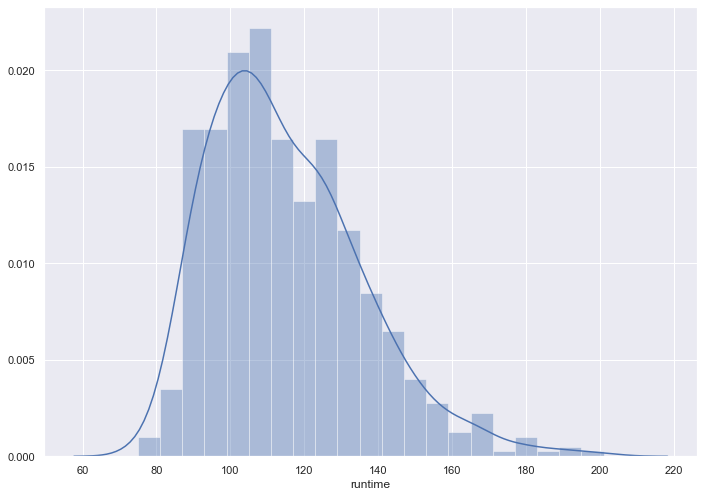

In [191]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.distplot(df_tem['runtime'])

In [88]:
df_tem.to_csv('../processed_dataset.csv',index=False)

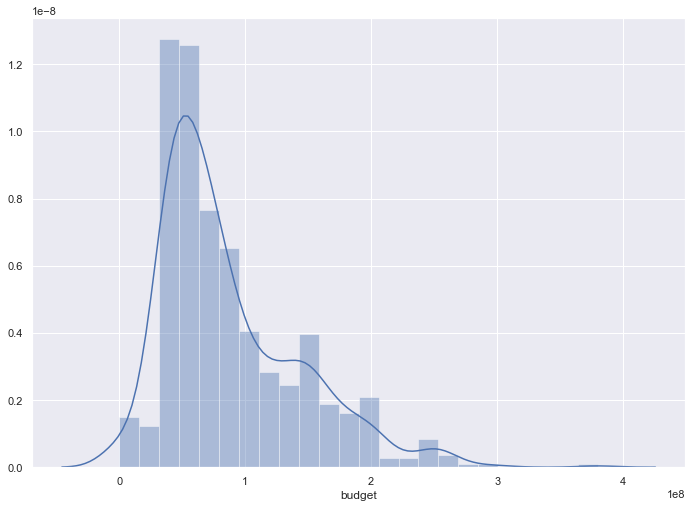

In [190]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.distplot(df_tem['budget'])

# Evaluate Algorithms

In [243]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [271]:
# This function will be called later to prepare our input data
def prepare_data(df):
    # a.) Use the `id` feature as the index column of the data frame
    df = df.set_index('id')

    # b.) Only use easy to process features
    #  Warning: huge information loss here, you should propably include more features in your production code.
    df = df[['budget', 'original_language' , 'runtime', 'status']]
    
    # c.) One-Hot-Encoding for all nominal data
    df = pd.get_dummies(df)
    
    # d.) The `runtime` feature is not filled in 2 of the rows. We replace those empty cells / NaN values with a 0.
    #  Warning: in production code, please use a better method to deal with missing cells like interpolation or additional `is_missing` feature columns.
    return df.fillna(0)


# 1.) Extract the target variable `revenue` and use the `id` column as index of that data frame
df_train_y = data[['id','revenue']].set_index('id')

# 2.) Prepare the training and test data by using the function we defined above
df_train_x = prepare_data(data)
#df_test_x  = prepare_data(IMDB_MOVIE_TEST_DATA)

# 3.) Create columns in train/test dataframes if they only exist in one of them (can happen through one hot encoding / get_dummies)
#  Example: There are no status=`Post Production` entries in the training set, but there are some in the test set.
#df_train_x, df_test_x = df_train_x.align(df_test_x, join='outer', axis=1, fill_value=0)

# 4.) Show the first rows of one of the prepared tables
df_train_x.head(10)



,budget,runtime,original_language_af,original_language_ar,original_language_cn,original_language_cs,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fa,original_language_fr,original_language_hi,original_language_id,original_language_it,original_language_ja,original_language_ko,original_language_nb,original_language_nl,original_language_no,original_language_pt,original_language_ru,original_language_th,original_language_zh,status_Post Production,status_Released
id,,,,,,,,,,,,,,,,,,,,,,,,,,
19995,237000000,162.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
285,300000000,169.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
206647,245000000,148.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
49026,250000000,165.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
49529,260000000,132.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
559,258000000,139.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
38757,260000000,100.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
99861,280000000,141.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
767,250000000,153.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [272]:
df_train_x.columns

Index(['budget', 'runtime', 'original_language_af', 'original_language_ar',
       'original_language_cn', 'original_language_cs', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_fa', 'original_language_fr', 'original_language_hi',
       'original_language_id', 'original_language_it', 'original_language_ja',
       'original_language_ko', 'original_language_nb', 'original_language_nl',
       'original_language_no', 'original_language_pt', 'original_language_ru',
       'original_language_th', 'original_language_zh',
       'status_Post Production', 'status_Released'],
      dtype='object')

In [273]:
# Load libraries
import pandas
import numpy
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [282]:
from sklearn.model_selection import train_test_split
    
# Split-out validation dataset
array = df_train_x.values
X = df_train_x.drop('budget', axis = 1)
y = df_train_x.budget
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)


In [283]:
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'mean_squared_error'


In [284]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [298]:
model_selection.cross_val_score?

In [297]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=num_folds, shuffle=False, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
    
    
    
    model_selection.cross_val_score(
    estimator,X,y=None,groups=None, scoring=None,
    cv='warn',
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score='raise-deprecating',
)

ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [231]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = cross_validate.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
	cv_results = cross_validate.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

AttributeError: 'function' object has no attribute 'KFold'

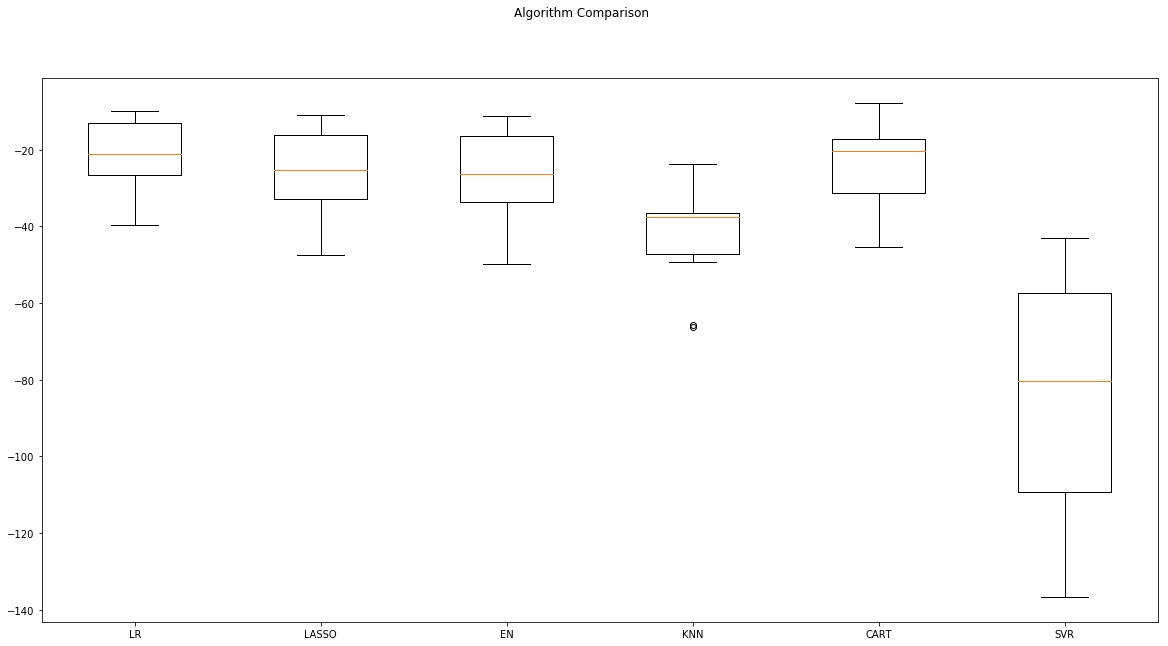

In [23]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.rcParams['figure.figsize'] = 20,10

In [24]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
	kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
	cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

ScaledLR: -21.379856 (9.414264)
ScaledLASSO: -26.607314 (8.978761)
ScaledEN: -27.932372 (10.587490)
ScaledKNN: -20.107620 (12.376949)
ScaledCART: -24.437963 (10.806240)
ScaledSVR: -29.633086 (17.009186)


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

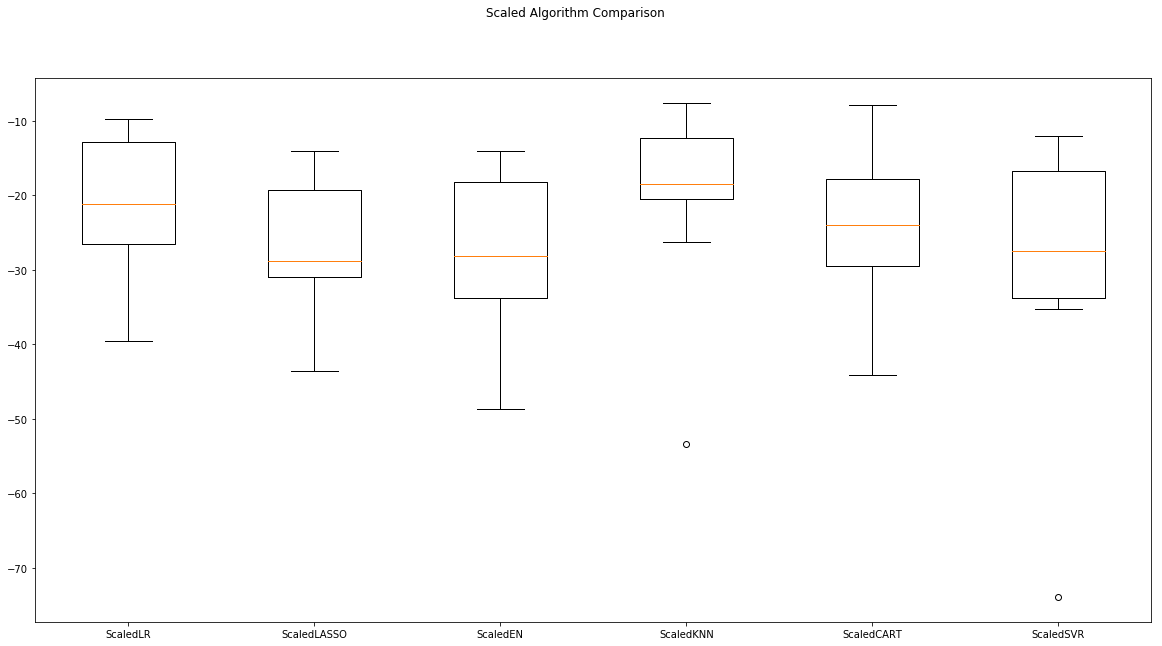

In [25]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.rcParams['figure.figsize'] = 20,10

In [26]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

Best: -18.172137 using {'n_neighbors': 3}
-20.169640 (14.986904) with: {'n_neighbors': 1}
-18.109304 (12.880861) with: {'n_neighbors': 3}
-20.063115 (12.138331) with: {'n_neighbors': 5}
-20.514297 (12.278136) with: {'n_neighbors': 7}
-20.319536 (11.554509) with: {'n_neighbors': 9}
-20.963145 (11.540907) with: {'n_neighbors': 11}
-21.099040 (11.870962) with: {'n_neighbors': 13}
-21.506843 (11.468311) with: {'n_neighbors': 15}
-22.739137 (11.499596) with: {'n_neighbors': 17}
-23.829011 (11.277558) with: {'n_neighbors': 19}
-24.320892 (11.849667) with: {'n_neighbors': 21}


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

In [27]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
	kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
	cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

ScaledAB: -15.105123 (7.052296)


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

ScaledGBM: -9.917102 (4.385270)


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

ScaledRF: -11.744937 (5.992251)


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

ScaledET: -11.762846 (6.224677)


C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


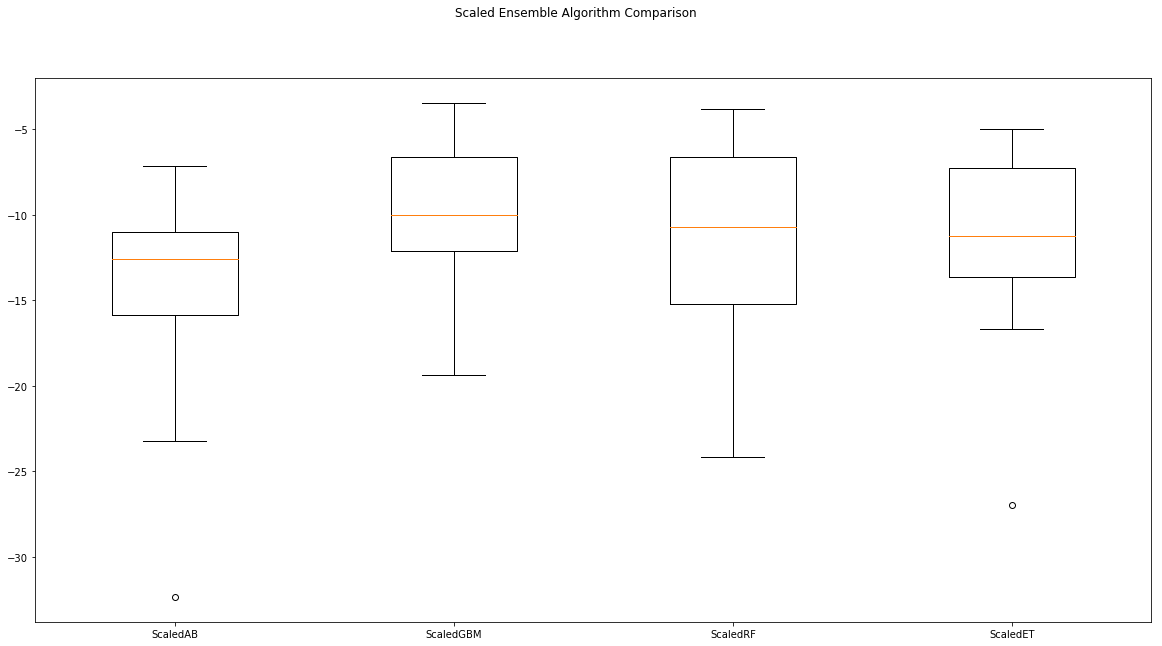

In [28]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.rcParams['figure.figsize'] = 20,10

In [31]:

# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\medwani\Anaconda3\l

Best: -9.356471 using {'n_estimators': 400}
-10.794196 (4.711473) with: {'n_estimators': 50}
-10.023378 (4.430026) with: {'n_estimators': 100}
-9.677657 (4.264829) with: {'n_estimators': 150}
-9.523680 (4.259064) with: {'n_estimators': 200}
-9.432755 (4.250884) with: {'n_estimators': 250}
-9.414258 (4.262219) with: {'n_estimators': 300}
-9.353381 (4.242264) with: {'n_estimators': 350}
-9.339880 (4.255717) with: {'n_estimators': 400}


# Make predictions on validation dataset

In [32]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=7, subsample=1.0, verbose=0,
             warm_start=False)

In [33]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))

11.8752520792
